In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv

### IV characterization

In [2]:


# Path to the Excel file
file_path = "../dataset/data_17_11_24.xlsx"  # Replace with your actual file path

# Lists to store voltage (V) and current (I)
V = []
I = []

try:
    # Read the Excel file using pandas
    data = pd.read_excel(file_path)
    print("Excel file loaded successfully!")
    
    # Assuming that the second and third columns correspond to V and I
    V = data.iloc[:, 2].tolist()  # Second column (Voltage)
    I = data.iloc[:, 3].tolist()  # Third column (Current)
    

except Exception as e:
    print(f"Error reading the Excel file: {e}")


Excel file loaded successfully!


In [3]:
R_ser_est = (V[-1] - V[-2])/(I[-1] - I[-2])
print(R_ser_est)

0.13750000000000037


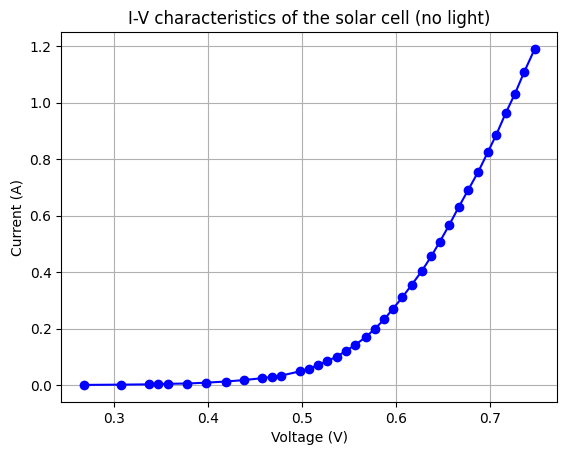

In [ ]:
plt.plot(V,I, '-o', c ='blue')
plt.title("I-V characteristics of the solar cell (no light)")
plt.xlabel("Voltage (V)")
plt.ylabel("Current (A)")
plt.grid()
# plt.savefig('IV_char.pdf')
plt.show()

### Intesity vs voltage relation

In [5]:
img_path = '..\\dataset\\img_17_11_24\\'
V = np.linspace(60, 75, 16)
img_v = []

for v in V:
    img = np.array(cv.imread(img_path+'v_0_'+str(int(v))+'.bmp'))
    img_v.append(img[:,:,0])

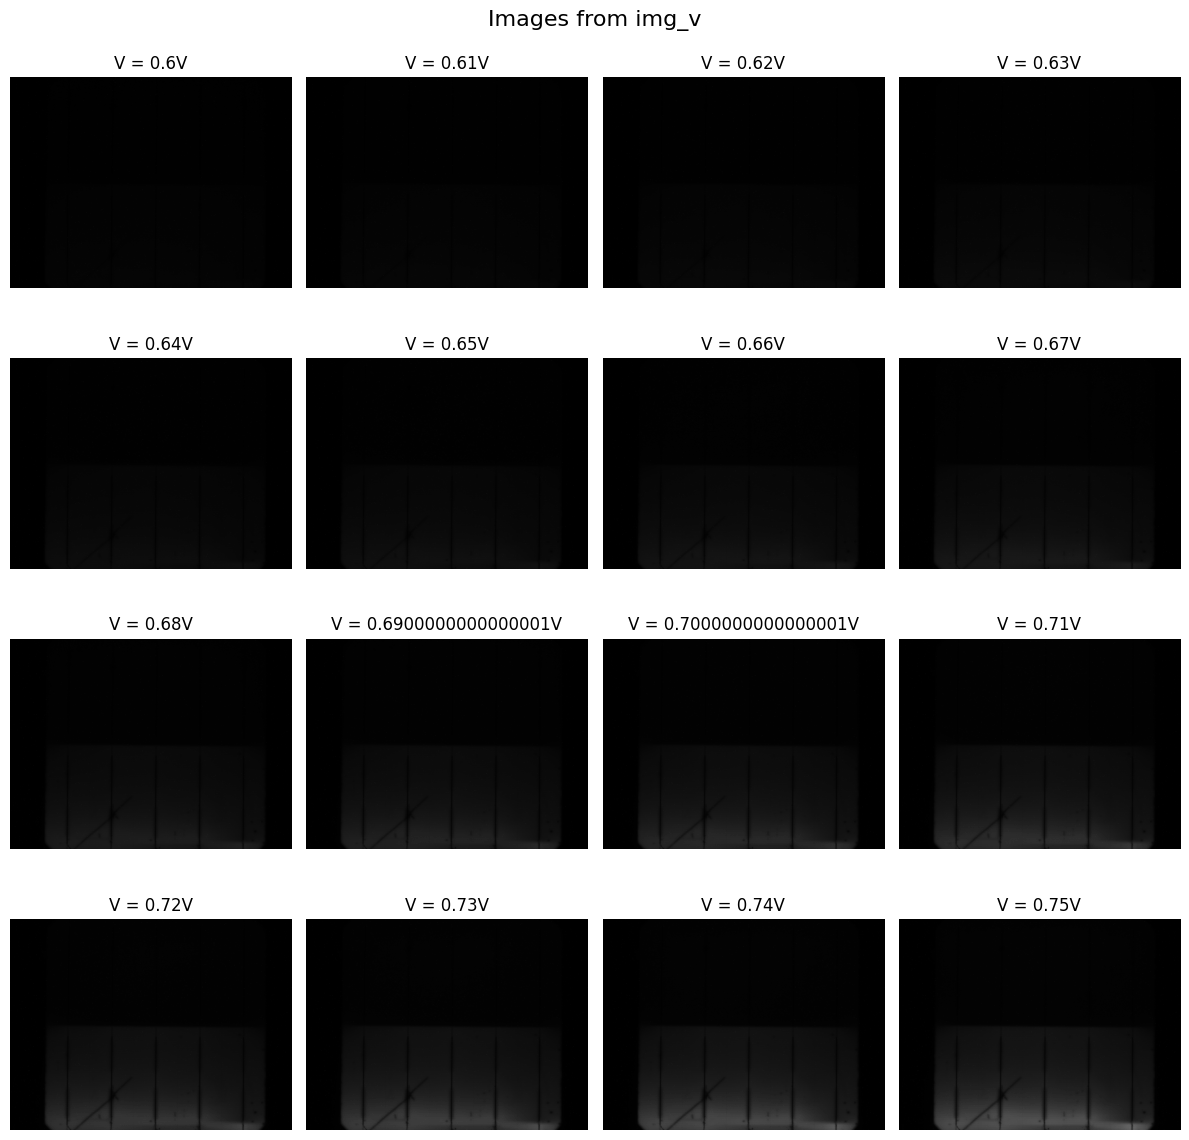

In [6]:
# Plot the images in a grid
fig, axes = plt.subplots(4, 4, figsize=(12, 12))  # Create a 4x4 grid
fig.suptitle('Images from img_v', fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < len(img_v):
        ax.imshow(img_v[i], cmap='gray')  # Show the image
        ax.set_title(f'V = {V[i]*0.01}V')  # Set the title
    ax.axis('off')  # Hide the axes

plt.tight_layout()
plt.show()

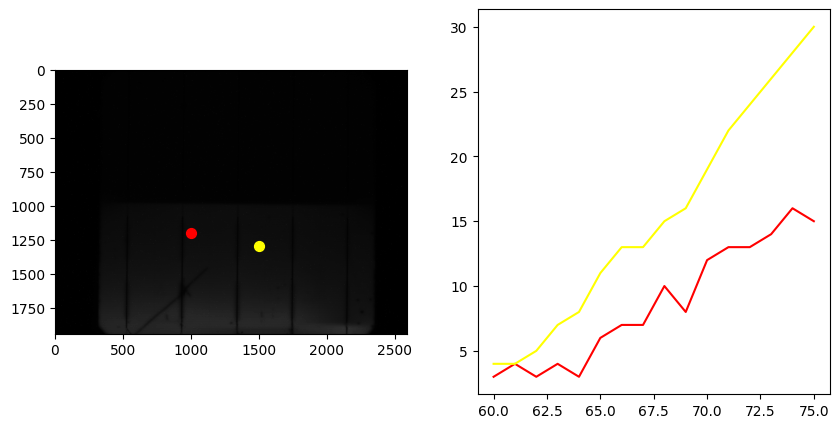

In [7]:
# choosing random coordinate in the img
x1 = 1000
y1 = 1200
int1 = []

x2 = 1500
y2 = 1300
int2 = []

for i in range(len(img_v)):
    int1.append(img_v[i][x1,y1])
    int2.append(img_v[i][x2,y2])

#anotate the coordinate
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_v[10], cmap='grey')
plt.scatter(x1, y1, color='red', s=50)  # Mark the selected point
plt.scatter(x2, y2, color='yellow', s=50)  # Mark the selected point
plt.draw()

plt.subplot(1,2,2)
plt.plot(V,int1, c = 'red')
plt.plot(V,int2, c = 'yellow')

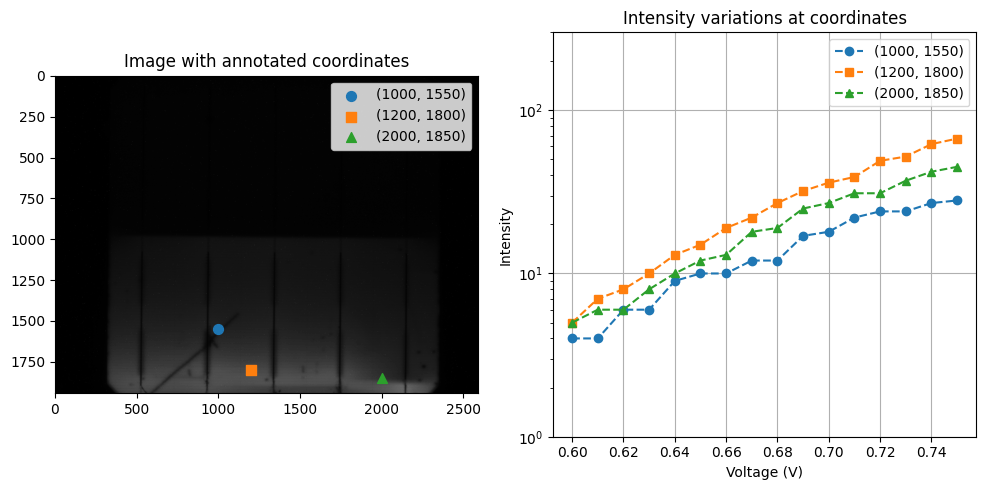

In [8]:
# Generalized function to analyze intensities at given coordinates
def analyze_coordinates(images, coordinates, voltage_values):
    """
    Analyze pixel intensities at specific coordinates across multiple images.

    Parameters:
    - images: List of images (numpy arrays).
    - coordinates: List of tuples [(x1, y1), (x2, y2), ...].
    - voltage_values: List of corresponding voltage values.

    Returns:
    - intensity_data: A dictionary mapping each coordinate to its intensity list.
    """
    intensity_data = {coord: [] for coord in coordinates}

    # Define markers for each coordinate
    markers = ['o', 's', '^', 'D', 'P', '*', 'X', 'v', '<', '>']  # Extend as needed
    if len(coordinates) > len(markers):
        raise ValueError("Number of coordinates exceeds the available markers.")

    # Extract pixel intensities for each coordinate across all images
    for img in images:
        for coord in coordinates:
            x, y = coord
            intensity_data[coord].append(img[y, x])  # Note: OpenCV uses (y, x) indexing
    
    # Visualization
    plt.figure(figsize=(10, 5))

    # Display one of the images with annotated coordinates
    plt.subplot(1, 2, 1)
    plt.imshow(images[15], cmap='gray')
    for coord, marker in zip(coordinates, markers):
        x, y = coord
        plt.scatter(x, y, s=50, label=f"({x}, {y})", marker=marker)  # Mark the coordinates with unique markers
    plt.legend()
    plt.title("Image with annotated coordinates")

    # Plot intensity variations for each coordinate
    plt.subplot(1, 2, 2)
    for coord, intensities, marker in zip(coordinates, intensity_data.values(), markers):
        plt.plot(voltage_values, intensities, f'--{marker}', label=f"({coord[0]}, {coord[1]})")
        plt.yscale('log')
    plt.xlabel("Voltage (V)")
    plt.ylabel("Intensity")
    plt.ylim([1, 300])
    plt.grid()
    plt.legend()
    plt.title("Intensity variations at coordinates")

    plt.tight_layout()
    # plt.savefig('V_vs_intensisty.pdf')
    plt.show()

    return intensity_data

# Define coordinates to analyze
coordinates_to_analyze = [(1000, 1550), (1200, 1800), (2000, 1850)]  # Example coordinates

# Call the function
intensity_data = analyze_coordinates(img_v, coordinates_to_analyze, V / 100)


### EL RS estiamtion paper implementation David Hinken

we took image at applied cell voltage 0.66V +/- 5mv
ie 0.665 V and 0.655 V (the currents are 0.6 A and 0.547 A, ie avg current = 0.5735)

In [9]:
#reading the two img captured
img_path = '..\\dataset\\img_17_11_24\\img_diff\\'

img1 = 0
img2 = 0

for i in range(1,10):
    img1_temp = (np.array(cv.imread(img_path+'V_0_665_'+str(i)+'.bmp')))/255
    img2_temp = (np.array(cv.imread(img_path+'V_0_655_'+str(i)+'.bmp')))/255
    img1 = img1 + img1_temp[:,:,0]/10
    img2 = img2 + img2_temp[:,:,0]/10


In [10]:
#Croping image

#  Load the image
img_path = '..\\dataset\\img_17_11_24\\V_0_70.bmp'

img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)  # Load as grayscalehresholding to identify the main portion

_, thresh = cv.threshold(img, 5, 255, cv.THRESH_BINARY)  # Adjust the threshold value (5 here) as needed

# Find contours
contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Find the largest contour (assumed to be the main portion)
main_contour = max(contours, key=cv.contourArea)

# Get bounding box of the largest contour
x, y, w, h = cv.boundingRect(main_contour) #finding the required coordinates

# Crop the image to the bounding box
cropped_img = img[y:y+h, x:x+w]

print(x,y,w,h)

315 977 2037 967


In [11]:
img1 = img1[y:y+h, x:x+w]
img2 = img2[y:y+h, x:x+w]

In [12]:
print("size of the image = ", np.shape(img1))

size of the image =  (967, 2037)


0.6313725490196078
0.0


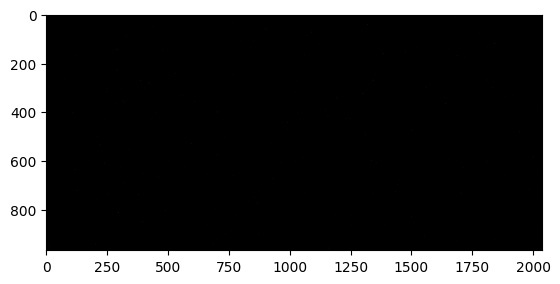

In [13]:
#reading the dark img
img_path = '..\\dataset\\img_17_11_24\\dark_img\\dark_img.bmp'
dark_img = (np.array(cv.imread(img_path)))/255
dark_img = dark_img[:,:,0]
dark_img = dark_img[y:y+h, x:x+w]
print(dark_img.max())
print(dark_img.min())
plt.imshow(dark_img, cmap='grey')

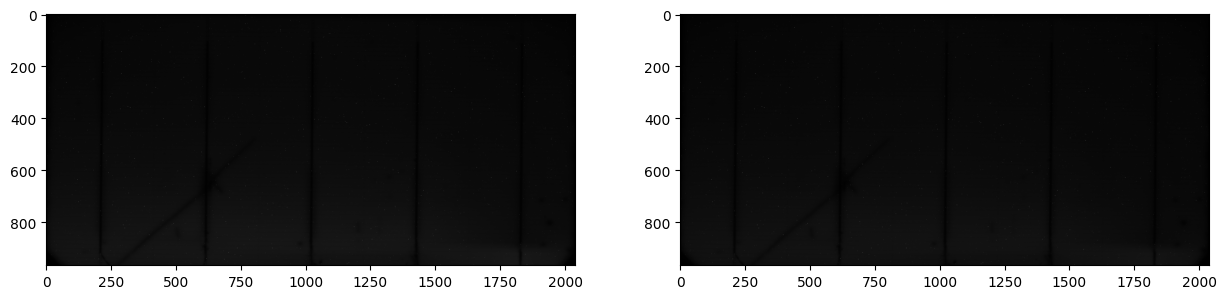

In [14]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1); plt.imshow(img1, cmap='grey')#; plt.title("$U + \Delta U/2$")
plt.subplot(1,2,2); plt.imshow(img2, cmap='grey')#; plt.title("$U - \Delta U/2$")

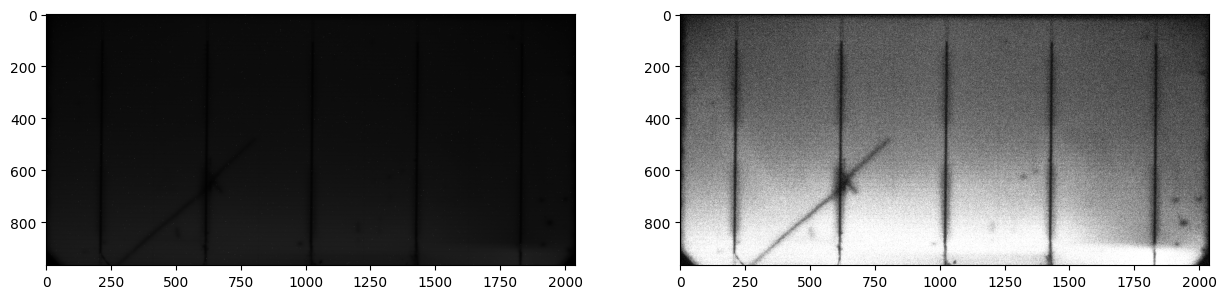

In [15]:
#adding the img1, img2
phi = np.clip((img1 + img2)/2 - dark_img , 0, 1)


#subtracting img1, img2
delta_V = 10e-3
delta_phi = np.clip((img1 - img2)/delta_V, 0, 1)

plt.figure(figsize=(15,10))
plt.subplot(1,2,1); plt.imshow(phi, cmap='grey')#; plt.title("$ \phi $")
plt.subplot(1,2,2); plt.imshow(delta_phi, vmin=0, vmax=1, cmap='grey')#; plt.title("$\Delta \phi$")
plt.show()

In [16]:
#finding scaling factor

I = (0.6 + 0.547)/2 #current at 0.66 V
A = (166*166/2)*10**(-6) #area of the illuminated cell
print("current = ", I)
print("area of the cell = ", A)
scl_fact = phi.sum()/I*A
print("scaling factor = ", scl_fact)

current =  0.5735
area of the cell =  0.013777999999999999
scaling factor =  1820.5843046125437


### Trial

In [17]:
img_path = '..\\dataset\\img_17_11_24\\'
V = np.linspace(60, 75, 16)
img_v = []

for v in V:
    img = np.array(cv.imread(img_path+'v_0_'+str(int(v))+'.bmp'))
    img_v.append(img[y:y+h, x:x+w, 0])

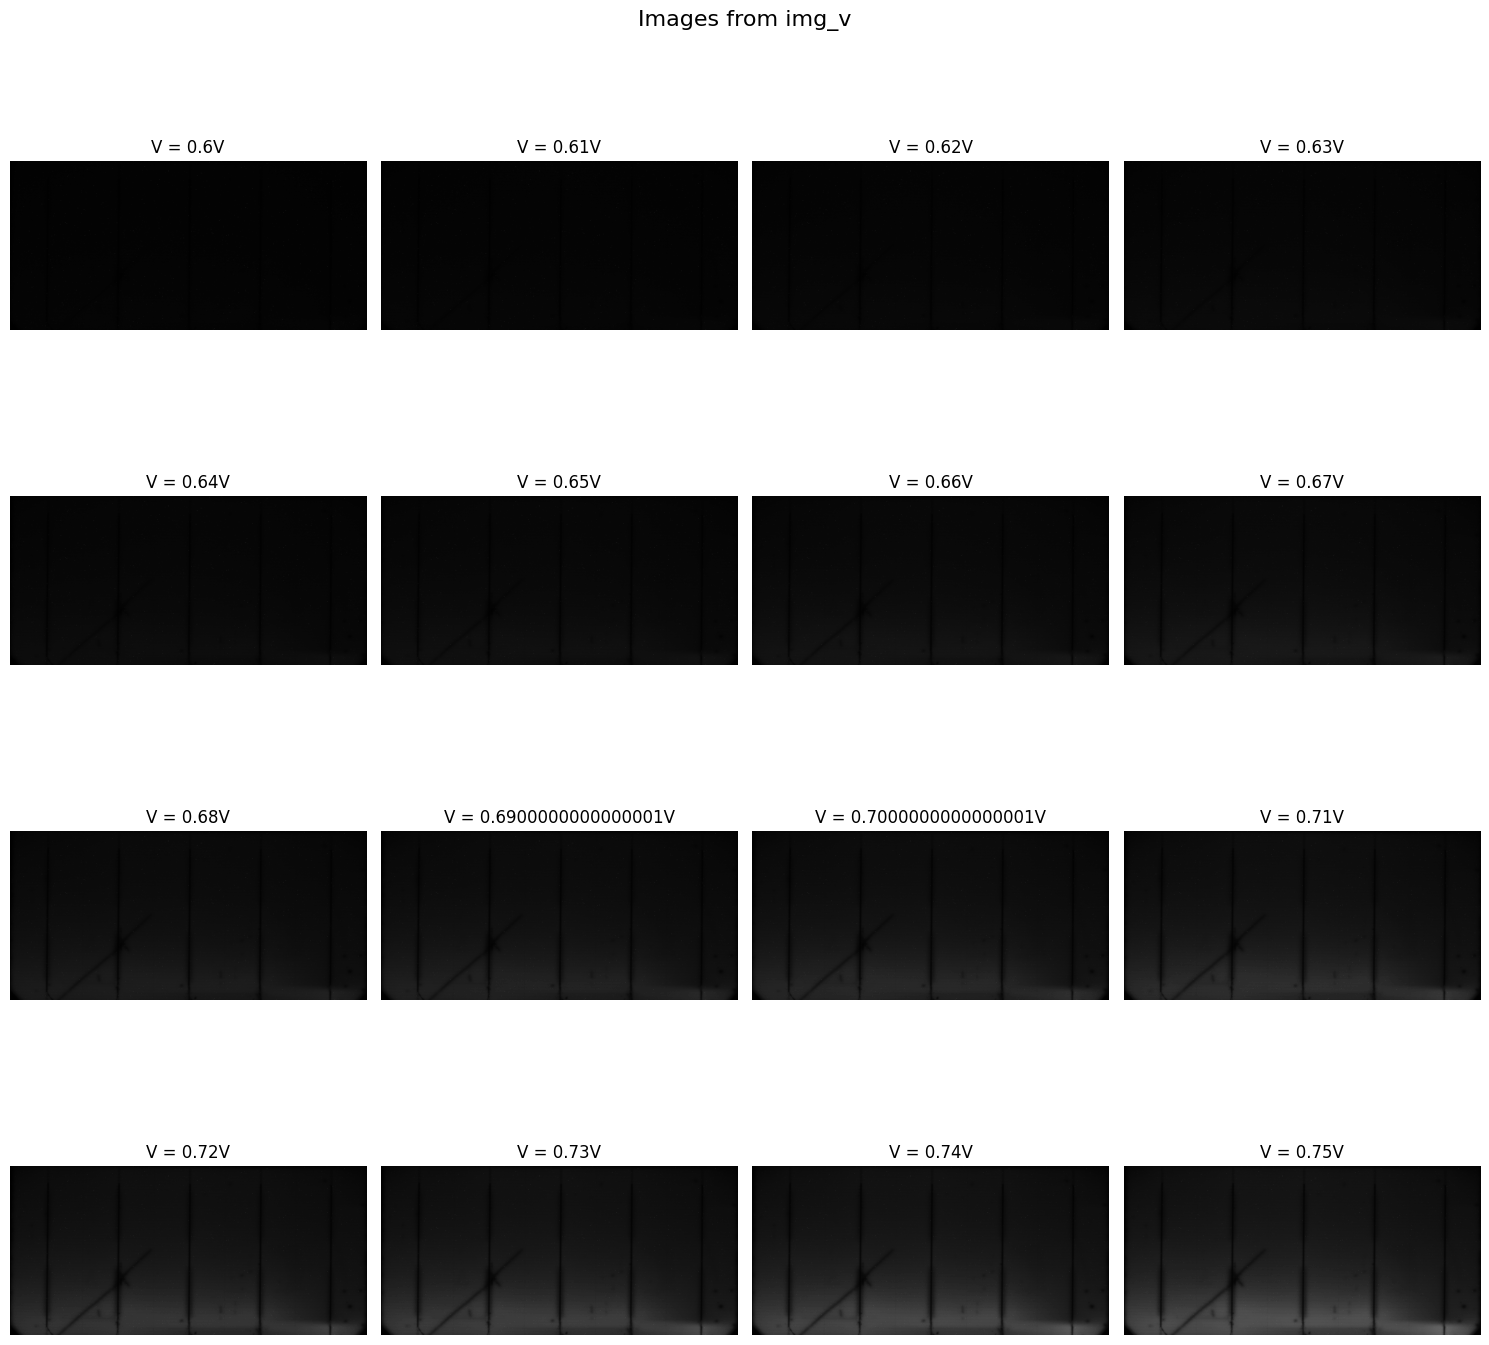

In [18]:
# Plot the images in a grid
fig, axes = plt.subplots(4, 4, figsize=(15, 15))  # Create a 4x4 grid
fig.suptitle('Images from img_v', fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < len(img_v):
        ax.imshow(img_v[i], cmap='gray')  # Show the image
        ax.set_title(f'V = {V[i]*0.01}V')  # Set the title
    ax.axis('off')  # Hide the axes

plt.tight_layout()
plt.savefig("EL_img_V_sweep.pdf")
plt.show()

In [19]:
img_phi = []
img_delta_phi = []
delta_V = 100e-3

for i in range(len(img_v)-1):
    phi = (img_v[i] + img_v[i+1])/2 - dark_img
    delta_phi = (img_v[i+1] - img_v[i])/delta_V
    img_phi.append(phi)
    img_delta_phi.append(delta_phi)

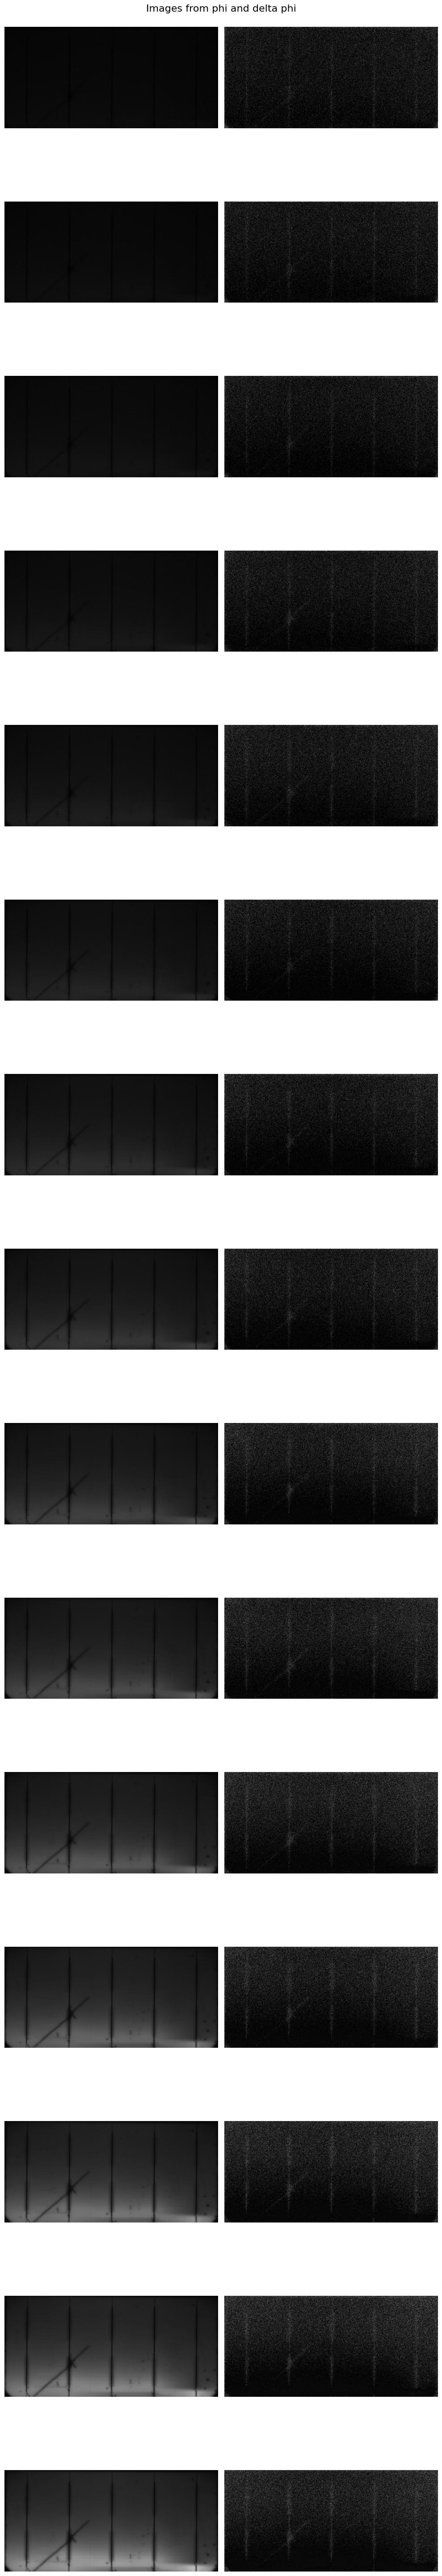

In [20]:
# Plot the images in a grid
fig, axes = plt.subplots(15, 2, figsize=(10, 60))  # Create a 4x4 grid
fig.suptitle('Images from phi and delta phi', fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < len(img_phi)*2:
        if(i%2 == 0):
            ax.imshow(img_phi[int(i/2)], cmap='gray')  # Show the image
#            ax.set_title(f'V = {V[i]*0.01}V')  # Set the title
        else:
            ax.imshow(img_delta_phi[int(i/2)], cmap='gray')  # Show the image
    ax.axis('off')  # Hide the axes

plt.tight_layout()
plt.show()

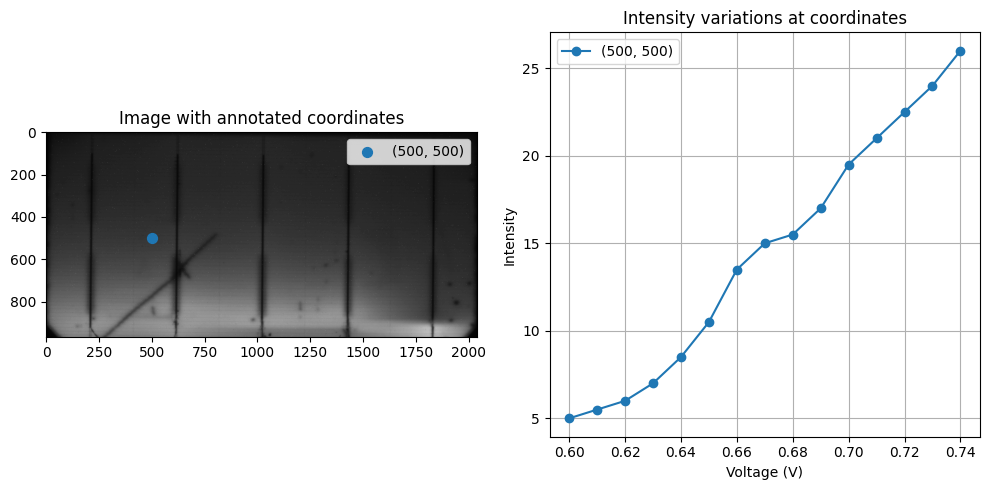

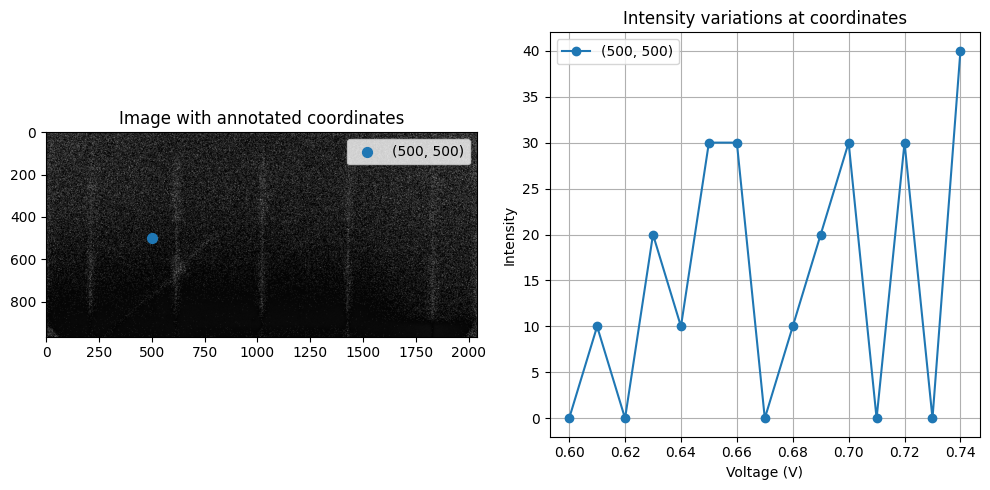

In [21]:
# Generalized function to analyze intensities at given coordinates
def analyze_coordinates(images, coordinates, voltage_values):
    """
    Analyze pixel intensities at specific coordinates across multiple images.

    Parameters:
    - images: List of images (numpy arrays).
    - coordinates: List of tuples [(x1, y1), (x2, y2), ...].
    - voltage_values: List of corresponding voltage values.

    Returns:
    - intensity_data: A dictionary mapping each coordinate to its intensity list.
    """
    intensity_data = {coord: [] for coord in coordinates}

    # Extract pixel intensities for each coordinate across all images
    for img in images:
        for coord in coordinates:
            x, y = coord
            intensity_data[coord].append(img[y, x])  # Note: OpenCV uses (y, x) indexing
    
    # Visualization
    plt.figure(figsize=(10,5))

    # Display one of the images with annotated coordinates
    plt.subplot(1, 2, 1)
    plt.imshow(images[14], cmap='gray')
    for coord in coordinates:
        x, y = coord
        plt.scatter(x, y, s=50, label=f"({x}, {y})")  # Mark the coordinates
    plt.legend()
    plt.title("Image with annotated coordinates")

    # Plot intensity variations for each coordinate
    plt.subplot(1, 2, 2)
    for coord, intensities in intensity_data.items():
        plt.plot(voltage_values[0:-1], intensities, '-o', label=f"({coord[0]}, {coord[1]})")
    plt.xlabel("Voltage (V)")
    plt.ylabel("Intensity")
    plt.grid()
    plt.legend()
    plt.title("Intensity variations at coordinates")

    plt.tight_layout()
    plt.show()

    return intensity_data

# Define coordinates to analyze
coordinates_to_analyze = [(500, 500)]  # Example coordinates

# Call the function
phi = analyze_coordinates(img_phi, coordinates_to_analyze, V/100)
delta_phi = analyze_coordinates(img_delta_phi, coordinates_to_analyze, V/100)

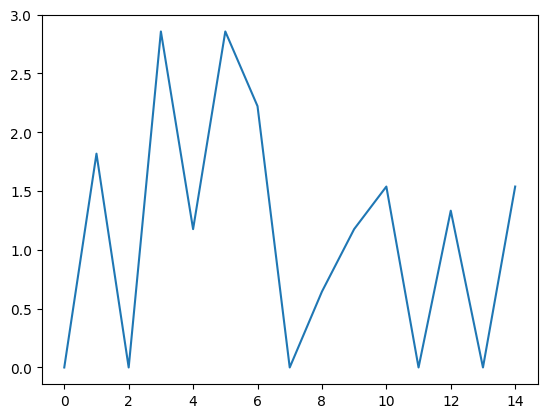

In [22]:
phi = np.array(phi[(500, 500)])
delta_phi = np.array(delta_phi[(500, 500)])
plt.plot(delta_phi/phi)